# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 17 ноября 2018, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 17 ноября, -4 балла после 06:00 24 ноября, -6 баллов после 06:00 1 декабря, -8 баллов после 06:00 8 декабря.

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст, если явно не указана такая возможность. В противном случае -1 балл
<hr\>

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext pycodestyle_magic

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [2]:
USER_NAME = u"Устинов".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print ("Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
) )

Имплементируйте обучение логистической регрессии с L2 регуляризацией с помощью метода  Stochastic Gradient Descent (SGD)


# Теоретическое введение



*** Что почитать по теории ***

Одна из лучших книг по ML $-$ "Pattern Recognition and Machine Learning" Bishop, Christopher. Логистическая регрессия в ней в параграфе 4.3

Логистическая регрессия является линейным классификатором, который оптимизирует так называемый функционал log loss:

$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right],$$
где  $y_i  \in \{0,1\}$ $-$ метка класса, $a_i$ $-$ предсказание алгоритма на объекте $x_i$. Модель пытается предсказать апостериорую вероятность объекта принадлежать к классу "1":
$$ p(y_i = 1 | x_i) = a(x_i) =  \sigma( \langle\,x_i,w\rangle ),$$
где $w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Функция $\sigma(x)$ $-$ нелинейная функция, пероводящее скалярное произведение объекта на веса в число $\in (0,1)$ (мы же моделируем вероятность все-таки!)

$$\sigma(x) = \frac{1}{1 + \exp(-x)}$$

Если внимательно посмотреть на функцию потерь, то можно заметить, что в зависимости от правильного ответа алгоритм штрафуется или функцией $-\log a_i$, или функцией $-\log (1 - a_i)$.



Часто для решения проблем, которые так или иначе связаны с проблемой переобучения, в функционал качества добавляют слагаемое, которое называют ***регуляризацией***. Итоговый функционал тогда принимает вид:
$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right] +  \frac{1}{C}R(w)$$

Самое понятие регуляризации введено основателем ВМК академиком Тихоновым https://ru.wikipedia.org/wiki/Метод_регуляризации_Тихонова

Идейно методика регуляризации заключается в следующем $-$ мы рассматриваем некорректно поставленную задачу (что это такое можно найти в интернете), для того чтобы сузить набор различных вариантов (лучшие из которых будут являться переобучением ) мы вводим дополнительные ограничения на множество искомых решений. На лекции Вы уже рассмотрели два варианта регуляризации.

$L1$ регуляризация:
$$R(w) = \sum_{j=1}^{D}|w_j|$$
$L2$ регуляризация:
$$R(w) =  \sum_{j=1}^{D}w_j^2$$

С их помощью мы ограничиваем модель в  возможности выбора каких угодно весов минимизирующих наш лосс, модель уже не сможет подстроиться под данные как ей угодно. 

Вам нужно добавить соотвествущую Вашему варианту регуляризацию в функцию потерь.

И так, мы поняли, какую функцию ошибки будем минимизировать, разобрались, как получить предсказания по объекту и обученным весам. Осталось разобраться, как получить оптимальные веса. Для этого нужно выбрать какой-то метод оптимизации. Отметим, что вне зависимости от алгоритма оптимизации, данная модель все равно будет называться ***логистической регрессией***.



Градиентный спуск является самым популярным алгоритмом обучения линейных моделей. В этом задании Вам предложат реализовать стохастический градиентный спуск или  мини-батч градиентный спуск (мини-батч на русский язык довольно сложно перевести, многие переводят это как "пакетный", но мне не кажется этот перевод удачным). Далее нам потребуется определение **эпохи**.
Эпохой в SGD и MB-GD называется один проход по **всем** объектам в обучающей выборки.
* В SGD градиент расчитывается по одному случайному объекту. Сам алгоритм выглядит примерно так:
        1) Перемешать выборку
        2) Посчитать градиент функции потерь на одном объекте (далее один объект тоже будем называть батчем)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* В Mini Batch SGD - по подвыборке объектов. Сам алгоритм выглядит примерно так::
        1) Перемешать выборку
        2) Почитать градиент функции потерь по мини-батчу (не забыть поделить на  число объектов в мини-батче)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* Для отладки алгоритма реализуйте возможность  вывода средней ошибки на обучении модели по объектам (мини-батчам). После шага градиентного спуска посчитайте значение ошибки на объекте (или мини-батче), а затем усредните, например, по ста шагам. Если обучение проходит корректно, то мы должны увидеть, что каждые 100 шагов функция потерь уменьшается. 
* Правило останова - максимальное количество эпох
    


### Примечание для случая L1-регуляризации:

При расчете производной по функции потерь c L1-регуляризацией  могут возникнуть сомнения по поводу производной части с модулями. 

Вам на выбор предлагаются следующией варианты:
* Считать субградиент $\partial|w_j| = sign(w_j)$ (проще, но с большой вероятностью не приведет к занулению коэффициентов)
* Метод SGD-Clipping из [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.1, страница 479, правая колонка снизу (чуть сложнее, но зато должно занулять)
* Cumulative Penalty из той же [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.2

# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Градиент для логистической регрессии.
* Посчитайте градиент функции потерь по весам для модели логистической регрессии с конкретно Вашей регуляризацией:

$$ \nabla_w L = \dots $$

 Отнеситесь к этому пункту максимально серьезно, этот градиент Вам нужно будет реализовать в задании.

***Ваше решение здесь***

$$\frac{\partial L}{\partial w_i} = -\frac{1}{N} \left[\sum_j y_j \frac{1}{\sigma(\langle\,x_j,w\rangle)} \frac{\partial \sigma(\langle\,x_j,w\rangle))}{\partial w_i} + (1-y_j)\frac{(-1)}{1 - \sigma(\langle\,x_j,w\rangle)} \frac{\partial \sigma(\langle\,x_j,w\rangle))}{\partial w_i} \right] +  \frac{2}{C}w_i $$

$$\frac{\partial \sigma(\langle\,x_j,w\rangle)}{\partial w_i} = -\frac{1}{(1 + \exp(-\langle\,x_j,w\rangle))^2} \exp(-\langle\,x_j,w\rangle) (-x_{j,i}) = \exp(-\langle\,x_j,w\rangle) x_{j,i} \sigma(\langle\,x_j,w\rangle)^2 = (1 - \sigma(\langle\,x_j,w\rangle)) \sigma(\langle\,x_j,w\rangle) x_{j,i}  $$

$$\frac{\partial L}{\partial w_i} = -\frac{1}{N} \left[\sum_j y_j \frac{1}{\sigma(\langle\,x_j,w\rangle)} (1 - \sigma(\langle\,x_j,w\rangle)) \sigma(\langle\,x_j,w\rangle) x_{j,i} - (1-y_j)\frac{1}{1 - \sigma(\langle\,x_j,w\rangle)} (1 - \sigma(\langle\,x_j,w\rangle)) \sigma(\langle\,x_j,w\rangle) x_{j,i} \right] +  \frac{2}{C}w_i $$

****Ответ: ****   $$\frac{\partial L}{\partial w_i} = -\frac{1}{N} \left[\sum_j y_j (1 - \sigma(\langle\,x_j,w\rangle)) x_{j,i} - (1-y_j) \sigma(\langle\,x_j,w\rangle) x_{j,i} \right] +  \frac{2}{C}w_i $$

Задача 2. Анализ поведения градиента.

Посчитав формулу градиента, подумайте, как будут меняться веса в зависимости  от "вида" ошибки: 
* Если правильный ответ был  класс "1", а значение $a(x_i)$ близко к нулю, после шага градиентного спуска веса в среднем увеличатся или уменьшатся?

* Если правильный ответ был  класс "0", а значение $a(x_i)$ близко к  единице, после шага градиентного спуска веса в среднем увеличатся или уменьшатся?

Вам такое поведение кажется логичным?

***Ваше решение здесь***

**1)**$\hspace{4mm}$ При $\hspace{3mm}y_j = 1 \hspace{3mm}$ и $\hspace{3mm}a(x_j) \approx 0\hspace{3mm}$ и если $\hspace{3mm}L_j\hspace{3mm}$ jый элемент суммы, то:  $\hspace{7mm}\frac{\partial L_j}{\partial w_i} \approx \frac{-1}{N}1(1-0)x_{j,i}\hspace{7mm}$ тогда, при $\hspace{3mm}x_{j,i} > 0\hspace{3mm}$ веса увеличиваются т.к. это значит, что при увеличении L веса уменьшаются(скорость отрицательна), но мы ****уменьшаем**** L(т.е. стремимся против уменьшения весов), соответственно при отрицательных признаках веса уменьшаются.

**2)**$\hspace{4mm}$ При $\hspace{3mm}y_j = 0 \hspace{3mm}$ и $\hspace{3mm}a(x_j) \approx 1\hspace{3mm}$:  $\hspace{7mm}\frac{\partial L_j}{\partial w_i} \approx \frac{1}{N}x_{j,i}\hspace{7mm}$ тогда, при $\hspace{3mm}x_{j,i} > 0\hspace{3mm}$ веса уменьшаются , соответственно при отрицательных признаках веса увеличиваются.

Не могу оценить насколько это логично

***конец***

Задача 3. Сравнение с линейной регрессией.

Как было рассказано на лекции, функция потерь линейной регрессии без регуляризации имеет вид:
$$ L( w ) = \frac{1}{N}\left[\sum_i (a(x_i) - y_i)^2 \right] $$
где $a(x_i)$ предсказания модели на $i$ объекте, $y_i$ $-$ значение целовой переменной на $i$ объекте, $N$ $-$ размер выборки.
$a(x_i)$ через веса и признаки вычисляется как:
$$ a(x_i) =  \langle\,x_i,w\rangle $$
где $x_i$ $-$ вектор признаков, $w$ $-$ вектор весов модели.
* Посчитайте градиент  функции потерь по весам для модели линейной регрессии:
$$ \nabla_w L = \dots $$
Как соотносится этот градиент с градиентом, возникающий в задаче логистической регресии? Вас это удивило, Вы это уже раньше заметили или Вам все равно? 

***Ваше решение здесь***

***Ответ:*** $\hspace{4mm} \frac{\partial L}{\partial w_i} = \frac{1}{N}\left[2\sum_j (\langle\,x_j,w\rangle - y_j)x_{j,i}\right]$

Задача 4.  Предсказываем вероятности.

Когда говорят о логистической регрессии, произносят фразу, что она "предсказывает вероятности положительного класса". Давайте разберемся, что же за этим стоит. Посчитаем математическое ожидание функции потерь и проверим, что предсказание алгоритма, оптимизирующее это мат. ожидание, будет являться вероятностью положительного класса. 

И так, функция потерь на объекте $x_i$, который имеет метку $y_i \in \{0,1\}$  для предсказания $a(x_i)$ равна:
$$L(y_i, b) =-[y_i == 1] \log a(x_i)  - [y_i == 0] \log(1 - a(x_i)) $$

Где $[]$ означает индикатор $-$ он равен единице, если значение внутри него истинно, иначе он равен нулю. Тогда мат. ожидание при условии конкретного $x_i$  по определение мат. ожидания дискретной случайной величины:
$$E(L | x_i) = -p(y_i = 1 |x_i ) \log a(x_i)  - p(y_i = 0 | x_i) \log( 1 - a(x_i))$$
* Докажите, что значение $a(x_i)$, минимизирующее данное мат. ожидание, в точности равно $p(y_i = 1 |x_i)$, то есть равно вероятности положительного класса.

Подсказка: возможно, придется воспользоваться, что  $p(y_i = 1 | x_i) + p(y_i = 0 | x_i) = 1$

***Ответ:***
$$ \frac{\partial E}{\partial a(x_i)} = - \frac{P(y_i = 1)}{a(x_i)} + \frac{P(y_i = 0)}{1 - a(x_i)} = \frac{-(1-a(x_i))P(y_i=1) + a(x_i)P(y_i=0)}{a(x_i)(1 - a(x_i))} = \frac{-P(y_i=1) + a(x_i)(P(y_i=1) + P(y_i=0))}{a(x_i)(1 - a(x_i))} = \frac{-P(y_i=1) + a(x_i)}{a(x_i)(1 - a(x_i))} $$

Тогда $\hspace{3mm} a(x_i) = P(y_i=1|x_i) \hspace{3mm}$ является значение, при котором матожидание минимально

#  Реализация логистической регрессии (6 баллов)

## Зачем нужны батчи?


Как Вы могли заметить из теоретического введения, что в случае SGD, что в случа mini-batch GD,  на каждой итерации обновление весов  происходит только по небольшой части данных (1 пример в случае SGD, batch примеров в случае mini-batch). То есть для каждой итерации нам *** не нужна вся выборка***. Мы можем просто итерироваться по выборке, беря батч нужного размера (далее 1 объект тоже будем называть батчом).

Легко заметить, что в этом случае нам не нужно загружать все данные в оперативную память, достаточно просто считать батч с диска, обновить веса, считать диска другой батч и так далее. В целях упрощения домашней работы, прямо с диска  мы считывать не будем, будем работать с обычными numpy array. 





## Немножко про генераторы в Python



Идея считывания данных кусками удачно ложится на так называемые ***генераторы*** из языка Python. В данной работе Вам предлагается не только разобраться с логистической регрессией, но  и познакомиться с таким важным элементом языка.  При желании Вы можете убрать весь код, связанный с генераторами, и реализовать логистическую регрессию и без них, ***штрафоваться это никак не будет***. Главное, чтобы сама модель была реализована правильно, и все пункты были выполнены. 

Подробнее можно почитать вот тут https://anandology.com/python-practice-book/iterators.html


К генератору стоит относиться просто как к функции, которая порождает не один объект, а целую последовательность объектов. Новое значение из последовательности генерируется с помощью ключевого слова ***yield***. Ниже Вы можете насладиться  генератором чисел Фибоначчи.

In [122]:
def fib(max_iter=4):
    a, b = 0, 1
    iter_num = 0
    while 1:
        yield a
        a, b = b, a + b
        iter_num += 1
        if iter_num == max_iter:
            break

Вот так можно сгенерировать последовательность Фибоначчи. 

Заметьте, что к генераторам можно применять некоторые стандартные функции из Python, например enumerate.

In [123]:
new_generator = fib()
for j, fib_val in enumerate(new_generator):
    print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Пересоздавая объект, можно сколько угодно раз генерировать заново последовательность. 

In [127]:
for i in range(0, 3):
    new_generator = fib()
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


А вот так уже нельзя.

In [128]:
new_generator = fib()
for i in range(0, 3):
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Концепция крайне удобная для обучения  моделей $-$ у Вас есть некий источник данных, который Вам выдает их кусками, и Вам совершенно все равно откуда он их берет. Под ним может скрывать как массив в оперативной памяти, как файл на жестком диске, так и SQL база данных. Вы сами данные никуда не сохраняете, оперативную память экономите.

Если Вам понравилась идея с генераторами, то Вы можете реализовать свой, используя прототип batch_generator. В нем Вам нужно выдавать батчи признаков и ответов для каждой новой итерации спуска. Если не понравилась идея, то можете реализовывать SGD или mini-batch GD без генераторов.

In [6]:
def batch_generator(X, y, shuffle=True, batch_size=1):
    """
    Гератор новых батчей для обучения
    X          - матрица объекты-признаки
    y_batch    - вектор ответов
    shuffle    - нужно ли случайно перемешивать выборку
    batch_size - размер батча ( 1 это SGD, > 1 mini-batch GD)
    Генерирует подвыборку для итерации спуска (X_batch, y_batch)
    """
    X_y = np.array(np.hstack((X, y.reshape(-1,1))))
    np.random.shuffle(X_y)
    X = X_y[:, :X.shape[1]]
    y = X_y[:,X.shape[1]:]
    n = X.shape[0] / batch_size
    for i in range(batch_size):
        X_batch = np.array(X[int(i*n):int((i+1)*n)])
        y_batch = np.array(y[int(i*n):int((i+1)*n)])
        yield (X_batch, y_batch)

# Теперь можно сделать генератор по данным ()
#  my_batch_generator = batch_generator(X, y, shuffle=True, batch_size=1):

In [16]:
#%%pycodestyle
import numpy as np


def sigmoid(X):
    """
    Вычисляем значение сигмоида.
    X - матрица объекты-признаки
    """

    # Your code Here
    return 1 / (1 + np.exp(-X))


from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, batch_generator, C=1, alpha=0.01, max_epoch=10):
        """
        batch_generator -- функция генератор, которой будем создавать батчи
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.errors_log = {'iter' : [], 'loss' : []}
        # Нужно инициализровать случайно веса
        self.weights = None
        
    def calc_loss(self, X_batch, y_batch):
        """
        Считаем функцию потерь по батчу 
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        """
        X = X_batch.astype(float)
        y = y_batch.astype(float)
        weights = self.weights.astype(float)
        first_part = np.sum([y[i] * np.log(sigmoid((X[i, :].dot(weights)))) \
                             for i in range(X.shape[0])])
        second_part = np.sum([(1 - y[i]) \
                              * np.log(1 - sigmoid((X[i, :].dot(weights)))) \
                              for i in range(X.shape[0])])
        regul = 1 / float(self.C) * np.sum([weights[i] * weights[i] \
                                            for i in range(X.shape[1])])
        loss = - 1 / float(X.shape[0]) * (first_part + second_part) + regul
        return loss
    
    def calc_loss_grad(self, X_batch, y_batch):
        """
        Считаем  градиент функции потерь по батчу (то что Вы вывели в задании 1)
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        """
        X = X_batch.astype(float)
        y = y_batch.astype(float)
        weights = self.weights.astype(float)
        
        loss_grad = []
        for i in range(X.shape[1]):
            first_part = np.sum([y[j] * (1 - sigmoid(np.dot(weights, X[j,:]))) \
                                 * X[j, i] for j in range(X.shape[0])])
            second_part = np.sum([(1 - y[j]) * sigmoid(np.dot(weights, X[j,:])) \
                                  * X[j, i] for j in range(X.shape[0])])
            d_l = - 1 / float(X.shape[0]) * (first_part - second_part) \
                  + 2 / self.C * weights[i]
            loss_grad.append(d_l)
        loss_grad = np.array(loss_grad)
        return loss_grad
    
    def update_weights(self, new_grad):
        """
        Обновляем вектор весов
        new_grad - градиент по батчу
        """
        weights = self.weights.astype(float)
        new_weights = weights - self.alpha * new_grad
        self.weights = new_weights
        return weights
    
    def fit(self, X, y):
        '''
        Обучение модели
        X - матрица объекты-признаки
        y - вектор ответов
        '''
        X_ = X
        X = np.c_[np.ones(X_.shape[0]), X_]
        self.weights = np.ones(X.shape[1], dtype=np.float64)

        for n in range(0, self.max_epoch):
            new_epoch_generator = self.batch_generator(X, y)
            for batch_num, new_batch in enumerate(new_epoch_generator):
                X_batch = np.array(new_batch[0])
                y_batch = np.array(new_batch[1])
                batch_grad = self.calc_loss_grad(X_batch, y_batch)
                
                batch_loss = self.calc_loss(X_batch, y_batch)
                self.update_weights(batch_grad)
                # Подумайте в каком месте стоит посчитать ошибку для отладки модели
                self.errors_log['iter'].append(batch_num)
                self.errors_log['loss'].append(batch_loss)
                
        return self
        
    def predict(self, X):
        '''
        Предсказание класса
        X - матрица объекты-признаки
        '''
        weights = self.weights.astype(float)
        X = np.array(X, dtype=np.float64)
        X_ = X
        X = np.c_[np.ones(X_.shape[0]), X_]
        # Желательно здесь использовать матричные операции между X и весами, например, numpy.dot 
        y_hat = np.rint([sigmoid((X[i, :].dot(weights))) for i in range(X.shape[0])])
        return y_hat
    
    def predict_proba(self, X):
        '''
        Предсказание вероятности положительного класса
        X - матрица объекты-признаки
        '''
        weights = self.weights.astype(float)
        X = np.array(X, dtype=np.float64)
        X_ = X
        X = np.c_[np.ones(X_.shape[0]), X_]
        y_hat_proba = [sigmoid((X[i, :].dot(weights))) for i in range(X.shape[0])]
        # Желательно здесь использовать матричные операции между X и весами, например, numpy.dot 
        return y_hat_proba


Запустите ваш алгоритм на синтетических данных. 

Выведите полученные веса и нарисуйте разделяющую границу между классами (используйте только первых два веса для первых двух признаков X[:,0], X[:,1] для отображения в 2d пространство ).  

In [20]:
def plot_decision_boundary(clf):
    ## Your code Here
    clf.fit(X, y)
    x = range(-4,8)
    plt.plot(x, -(clf.weights[0] + clf.weights[1] * x) / clf.weights[2])

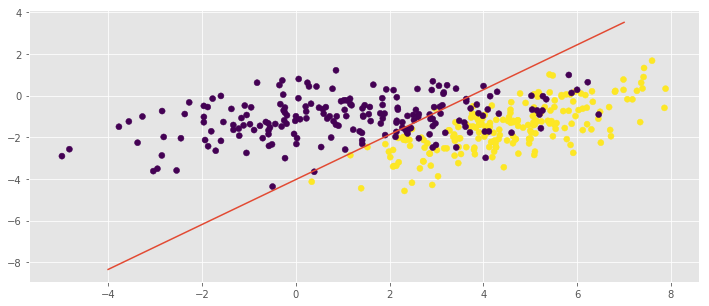

In [21]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

clf = MySGDClassifier(batch_generator=batch_generator,
                          C=1000, max_epoch=100, alpha=1)
plot_decision_boundary(clf)

plt.scatter(X[:,0], X[:,1], c=y)

Далее будем анализировать Ваш алгоритм. 
Для этих заданий используйте датасет ниже.

In [22]:
from sklearn.datasets import make_classification

In [23]:
X, y = make_classification(n_samples=10000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимость вашего метода на этом датасете: изобразите график  функции потерь, усредненной по $N$ шагам градиентого спуска, для разных `alpha` (размеров шага). Разные `alpha` расположите на одном графике. 

$N$ можно брать 10, 50, 100 и т.д. 

In [24]:
## Your Code Here
alphas = [0.1, 0.4, 0.7, 1]
errors = []
for i in alphas:
    clf = MySGDClassifier(batch_generator=batch_generator, C=1000, alpha=i, max_epoch=100)
    clf.fit(X, y)
    errors.append(clf.errors_log['loss'])

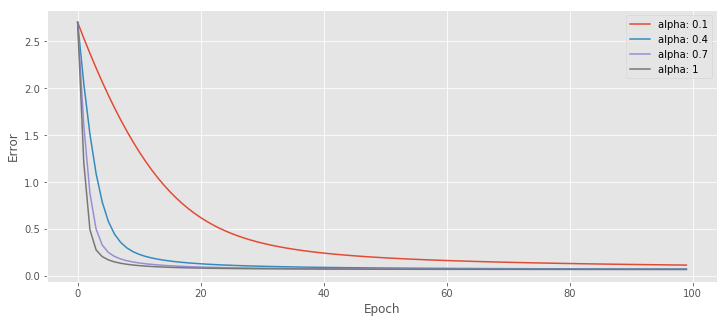

In [25]:
i = 0
for error in errors:
    plt.plot(np.arange(len(error)), error, label='alpha: {}'.format(alphas[i]))
    i += 1
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend()

Что Вы можете сказать про сходимость метода при различных `alpha`? Какое значение стоит выбирать для лучшей сходимости?

Изобразите график среднего значения весов модели в зависимости от коеф. регуляризации С из `np.logspace(3, -3, 10)` 

In [28]:
## Your Code Here
# уменьшил выборку, т.к. иначе слишком долго считает
X = X[:700]
y = y[:700]
Cs = np.logspace(3, -3, 10)
weights_mean = []
for C in Cs:
    clf = MySGDClassifier(batch_generator=batch_generator, C=C, alpha=0.7, max_epoch=50)
    clf.fit(X, y)
    weights_mean.append(clf.weights.mean())

/home/Albert/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log
/home/Albert/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in multiply
/home/Albert/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log
/home/Albert/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in multiply
/home/Albert/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: overflow encountered in double_scalars


Text(0.5,1,'second 5 C using log')

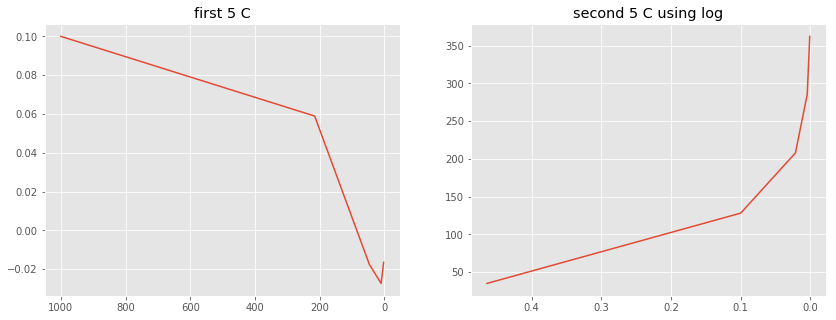

In [38]:
fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(Cs[:5], weights_mean[:5])
ax1.invert_xaxis()
ax1.set_title("first 5 C")

ax2.plot(Cs[5:], np.log(weights_mean[5:]))
ax2.invert_xaxis()
ax2.set_title("second 5 C using log")

Довольны ли Вы, насколько сильно уменьшились Ваши веса? Если нет, то как можно было бы уменьшать их еще сильнее?

# Боевое применение (2  балла)

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная онлайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

## Данные

Обучающую выборку и тестовую выборку с ответами можно скачать [отсюда](https://cloud.mail.ru/public/BEon/4Rrdqqvng)

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

In [39]:
# Загрузка данных для обучения
filepath = 'trainingData_tabular/trainingData_tabular_chunk1.csv'
df_data = pd.read_csv(filepath, sep=',')

In [40]:
df_data.head()

,gamestate_id,decision,turn,opponent.armor,opponent.attack,opponent.hero_card_id,opponent.hp,opponent.special_skill_used,opponent.weapon_durability,opponent.crystals_all,...,player.played.hp_current,player.played.hp_max,player.hand.nOfMinions,player.hand.nOfSpells,player.hand.nOfWeapons,player.hand.nOfCards,player.hand.nOfPlayable,player.hand.attack,player.hand.crystals_cost,player.hand.hp
0,4687346,1,14,0,0,798,5,0,0,10,...,20,23,4,0,1,5,0,20,22,17
1,3270826,1,7,0,0,754,22,0,0,6,...,16,17,3,2,2,7,0,17,26,20
2,3189487,1,5,3,0,612,29,0,0,4,...,0,0,5,0,0,5,2,26,28,27
3,4098946,1,8,0,0,390,26,0,0,7,...,2,2,7,1,1,9,9,36,44,36
4,2661127,0,13,0,0,25,30,0,0,10,...,7,7,4,0,0,4,4,13,13,14


In [41]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [42]:
df_data.head().T

gamestate_id,4687346,3270826,3189487,4098946,2661127
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hero_card_id,798,754,612,390,25
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1


In [45]:
# Распределение классов
df_data.decision.mean()
# Примерно поровну

0.504702

## Обучение модели

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Преобразуйте категориальные переменные с помощью one-hot кодирования, добавьте к датасету и удалите прежние столбцы. (Вы точно понимаете, зачем это нужно сделать? Если нет, спросите обязательно преподавателя!)
* Стандартизируйте признаки с помощью `StandartScaller` из sklearn (Вы точно понимаете, зачем это нужно сделать? Если нет, спросите обязательно преподавателя!)
* Обучите модель, подбирая параметры на отложенном контроле

In [46]:
## Youd Code Here
df_data = pd.get_dummies(df_data, columns=['opponent_hero_card_id', 'player_hero_card_id'])
X = df_data.drop(['decision'], axis=1)
y = np.array(df_data.decision)

In [47]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# сократил выборку, т.к. иначе будет очень долго считаться
X_ = X_train[:1000]
y_ = y_train[:1000]

In [48]:
from sklearn.model_selection import GridSearchCV

params = {'alpha': [0.2, 0.5, 0.8, 1], 'C': [100, 500, 1000]}
clf = MySGDClassifier(batch_generator, max_epoch=50)
grid_search = GridSearchCV(clf, params, cv=5)
grid_search.fit(X_, y_)

GridSearchCV(cv=5, error_score='raise',
       estimator=MySGDClassifier(C=1, alpha=0.01,
        batch_generator=<function batch_generator at 0x7fadc910d840>,
        max_epoch=50),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.2, 0.5, 0.8, 1], 'C': [100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [49]:
grid_search.best_params_

{'C': 100, 'alpha': 0.8}

## Применение модели 
* Подготовьте тестовые данные  к подаче на вход в алгоритму (нужно сделать такие же преобразования, как при обучении)
* Примените модель оцените качество на тесте с помощью меры ROC-AUC (имплментацию взять из sklern.metrics)


In [50]:
# Загрузка данных для тестирования
filepath_test = 'trainingData_tabular/trainingData_tabular_chunk2.csv'
df_data_test = pd.read_csv(filepath_test, sep=',')

In [51]:
## Youd Code Here
df_data_test.columns = df_data_test.columns.str.replace('.', '_')
df_data_test = df_data_test.set_index('gamestate_id')
df_data_test = pd.get_dummies(df_data_test, columns=['opponent_hero_card_id', 'player_hero_card_id'])

X = df_data.drop(['decision'], axis=1)
y = np.array(df_data.decision)

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_ = X[:500]
y_ = y[:500]

In [52]:
y_hat = grid_search.predict(X_)

In [53]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_, y_hat)

0.681939187888896

# Контрольные вопросы
Постарайтесь максимально развернуто и честно ответить на вопросы. Они охватывают тему линейных моделей и скорее нужны преподавателям, чтобы понимать, что именно Вы усвоили плохо. Надеюсь, они подскажут, что именно в теме Вы не понимаете или наоборот порадают, что Вы все знаете ^_^

* Опишите основные, на Ваш взгляд,  отличия логистической регрессии от линейной регрессии. Почему, на ваш взгляд, задачу классификации решают логистической, а не линейной регрессией?

***Ваше ответ здесь***

***1)*** Основное отличие в том что линейная регрессия решает задачу регрессии, а логистическая - классификации. Как следствие мы потимизируем разные функционалы.

***2)*** Не получится решить задачу классификации линейной моделью, т.к. нам нужна непрерывная целевая переменная.

* Как Вы думаете, для каких типов задач (объем данных, число признаков, типы признаков) стоит отдавать предпочтение линейным моделям?

***Ваше ответ здесь***

При большом количестве данных сложные модели могут очень сильно переобучитсься, поэтому иногда в таких ситуациях имеет место линейная модель. Признаки очень желательно должны быть вещественными, непрерывными, и обязательно линейно не зависимыми.

* Пусть на обучении мы имеем выборку размера $N$, число признаков $D$. Чему равна алгоритмическая сложность одного шага градиентного спуска? Cтохастического градиентного спуска?  Сложность предсказания на одном объекте?

***Ваше ответ здесь***

O(N*D^2) для одного шага градиентного и стохастического градиентного спусков. Сложность для одного элемента O(D)

* В чем преимущества стохастического градиентного спуска (в том числе мини-батч) над обычным градиентным спуском? В чем его недостатки? Рассмотрите несколько аспектов $-$ скорость сходимости, необходимость загрузки всех данных в оперативную память, сложность вычисления одного шага.

***Ваше ответ здесь***

***1)*** Сходимость как правило быстрее.

***2)*** В случае мини-батча необязательно хранить в оперативной памяти всю выборку.

***3)*** Сложность уменьшается, т.к. градиент надо считать не по всей выборке.

* Как Вы думаете, при обучении линейной модели с помощью SGD, ошибку на новом объекте стоит считать до итерации спуска на этом объекте или после? Почему Вы так думаете? Возможно, Вам будет интересно ознакомиться с http://hunch.net/~jl/projects/prediction_bounds/thesis/mathml/thesisse44.xml

***Ваше ответ здесь***

Мне кажется, что после итерациии, т.к. мы можем отследить насколько данный шаг итерации уменьшил лосс. Иначе если мы будем считать до итерации, то мы так и не узнаем как изменился лосс, после последней итерации.

* Как Вы думаете, во времена такого бума нейронных сетей, остаются ли популярными линейные модели, или это уже пережиток прошлого? Почему Вы так думаете?

***Ваше ответ здесь***

Остаются, т.к. они интуитивно понятны, не требуют серьёзной настройки параметров, и что самое важное - линейные модели не ресурсо-затратны. Не надо иметь несколько видеокарт и много оперативной памяти, чтобы эффективно использовать линейные модели.

* Какие аспекты обучения линейных моделей Вам показались непонятными? Какое место стоит дополнительно объяснить?

***Ваше ответ здесь***

По ощущениям всё более-менее понятно.

Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***